## Qiskit Circuit Library

We take a brief tour through the `qiskit.circuit.library` module with some examples.

### How can I compute 1 + 1 = 2 on a quantum computer?

On a classical computer you write a program, it gets translated to bytecode, loaded into memory and executed on CPU.

In [1]:
1+1

2

On a quantum computer you have to use qubits and gates to accomplish this (a "quantum circuit"). Quantum circuits must be made from reversible gates (in addition to reset and measurement as needed). In the example below, AND (irreversible) gets converted to a Toffoli/CCX gate (reversible).

| a | b || carry | sum |
| --- | --- || --- | --- |
| 0 | 0 || 0 | 0 |
| 0 | 1 || 0 | 1 |
| 1 | 0 || 0 | 1 |
| 1 | 1 || 1 | 0 |

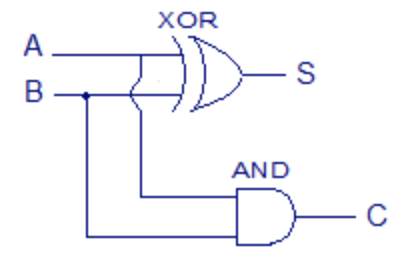

In [2]:
from qiskit import QuantumRegister, QuantumCircuit
a = QuantumRegister(1, 'a')
b = QuantumRegister(1, 'b')
c = QuantumRegister(1, 'c')
one_bit_adder = QuantumCircuit(a, b, c)
one_bit_adder.reset(c)
one_bit_adder.barrier()
one_bit_adder.ccx(a, b, c)
one_bit_adder.cx(a, b)
one_bit_adder.draw(plot_barriers=False)

a_0: ────────■────■──
             │  ┌─┴─┐
b_0: ────────■──┤ X ├
           ┌─┴─┐└───┘
c_0: ─|0>──┤ X ├─────
           └───┘

In [3]:
import qiskit.quantum_info as qi

state_a = qi.Statevector.from_int(1, 2)
state_b = qi.Statevector.from_int(1, 2)
state_c = qi.Statevector.from_int(0, 2)  # clean ancilla
state_in = state_a.expand(state_b).expand(state_c)
state_out = state_in.evolve(one_bit_adder)
state_out = qi.partial_trace(state_out, [0])
print(state_out.probabilities_dict())

{'10': 1.0}


In [4]:
from qiskit.providers.aer import QasmSimulator
from qiskit import assemble
sim = QasmSimulator()
circ = assemble(one_bit_adder.measure_all(inplace=False), shots=1000)
res = sim.run(circ).result()
res.get_counts()

{'000': 1000}

### 1. Wouldn't it be nice if I could just use an adder without worrying about these details? Are there better adders?

#### a) Cuccaro Adder (https://arxiv.org/pdf/quant-ph/0410184.pdf)

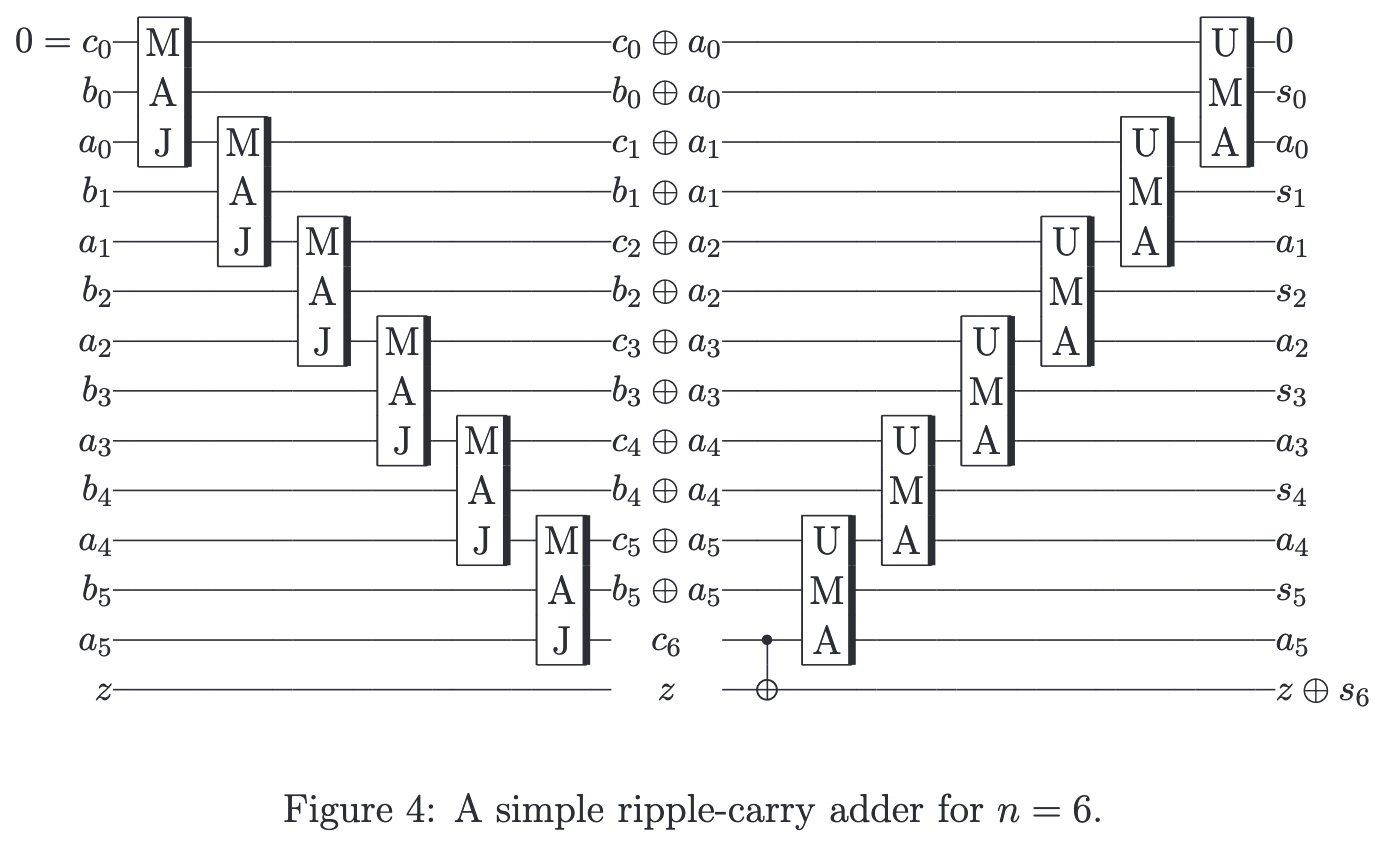

In [5]:
from qiskit.circuit.library import CDKMAdder
import qiskit.quantum_info as qi

num_qubits = 4
cdkm_adder = CDKMAdder(num_qubits)

cin = cdkm_adder.qregs[0]
a = cdkm_adder.qregs[1]
b = cdkm_adder.qregs[2]
cout = cdkm_adder.qregs[3]

cin_state = qi.Statevector.from_int(0, 2**cin.size)
a_state = qi.Statevector.from_int(8, 2**a.size)
b_state = qi.Statevector.from_int(3, 2**b.size)
cout_state = qi.Statevector.from_int(0, 2**cout.size)

in_state = cin_state.expand(a_state).expand(b_state).expand(cout_state)
out_state = in_state.evolve(cdkm_adder)

in_probs = in_state.probabilities_dict(decimals=4)
out_probs = out_state.probabilities_dict(decimals=4)

s = qi.partial_trace(out_state, list(range(0, a.size + 1))).probabilities_dict()

print(cdkm_adder.draw(fold=100))
print('sum: ', {int(k, 2): v for k, v in s.items()})

        ┌──────┐                                                     ┌──────┐
 cin_0: ┤0     ├─────────────────────────────────────────────────────┤0     ├
        │      │┌──────┐                                     ┌──────┐│      │
   a_0: ┤2     ├┤0     ├─────────────────────────────────────┤0     ├┤2     ├
        │      ││      │┌──────┐                     ┌──────┐│      ││      │
   a_1: ┤      ├┤2     ├┤0     ├─────────────────────┤0     ├┤2     ├┤      ├
        │  maj ││      ││      │┌──────┐     ┌──────┐│      ││      ││  uma │
   a_2: ┤      ├┤      ├┤2     ├┤0     ├─────┤0     ├┤2     ├┤      ├┤      ├
        │      ││  maj ││      ││      │     │      ││      ││  uma ││      │
   a_3: ┤      ├┤      ├┤      ├┤2     ├──■──┤2     ├┤      ├┤      ├┤      ├
        │      ││      ││  maj ││      │  │  │      ││  uma ││      ││      │
   b_0: ┤1     ├┤      ├┤      ├┤      ├──┼──┤      ├┤      ├┤      ├┤1     ├
        └──────┘│      ││      ││  maj │  │  │  uma ││      ││  

#### b) Draper adder (https://arxiv.org/pdf/quant-ph/0008033.pdf)

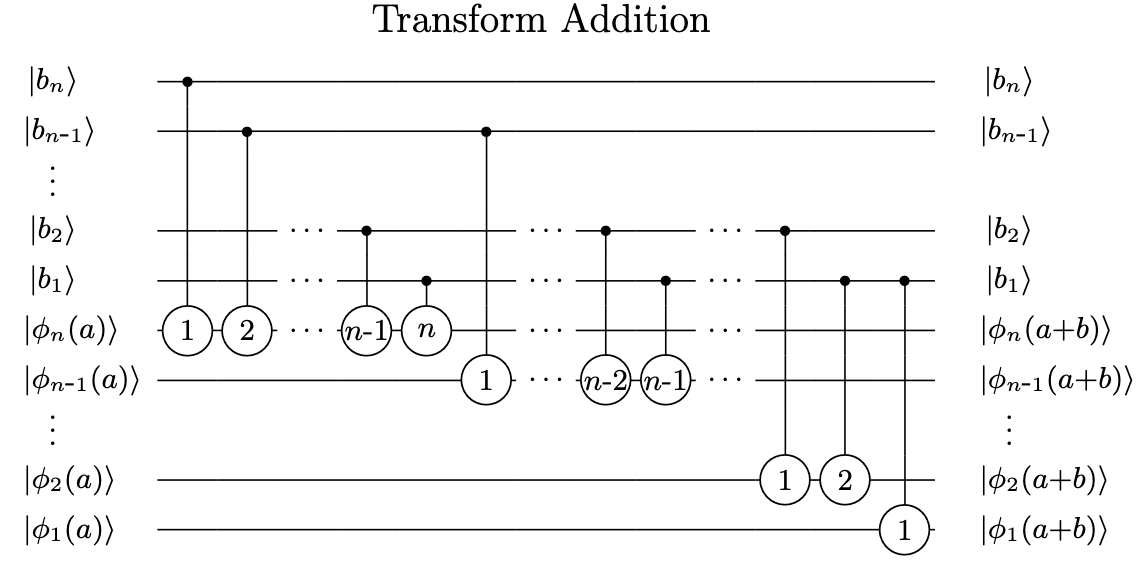

In [6]:
from qiskit.circuit.library import DraperAdder
import qiskit.quantum_info as qi

num_qubits = 4
draper_adder = DraperAdder(num_qubits)
x = qi.Statevector.from_int(9, 2**num_qubits)
y = qi.Statevector.from_int(6, 2**num_qubits)
initial_state = x.tensor(y)
final_state = initial_state.evolve(draper_adder)
final_state = qi.partial_trace(final_state, list(range(num_qubits, 2*num_qubits)))
s = final_state.probabilities_dict(decimals=4)

print(draper_adder.draw(plot_barriers=False, fold=100, reverse_bits=True))
print('sum: ', {int(k, 2): v for k, v in s.items()})

                                                                                        
b_3: ─────────■─────────────────────────────────────────────────────────────────────────
              │                                                                         
b_2: ─────────┼────■─────────────────────■──────────────────────────────────────────────
              │    │                     │                                              
b_1: ─────────┼────┼──────■──────────────┼────■──────────────■──────────────────────────
              │    │      │              │    │              │                          
b_0: ─────────┼────┼──────┼──────■───────┼────┼──────■───────┼────■───────■─────────────
     ┌──────┐ │pi  │pi/2  │pi/4  │pi/8   │    │      │       │    │       │    ┌───────┐
a_3: ┤3     ├─■────■──────■──────■───────┼────┼──────┼───────┼────┼───────┼────┤3      ├
     │      │                            │pi  │pi/2  │pi/4   │    │       │    │       │
a_2: ┤2     ├────────

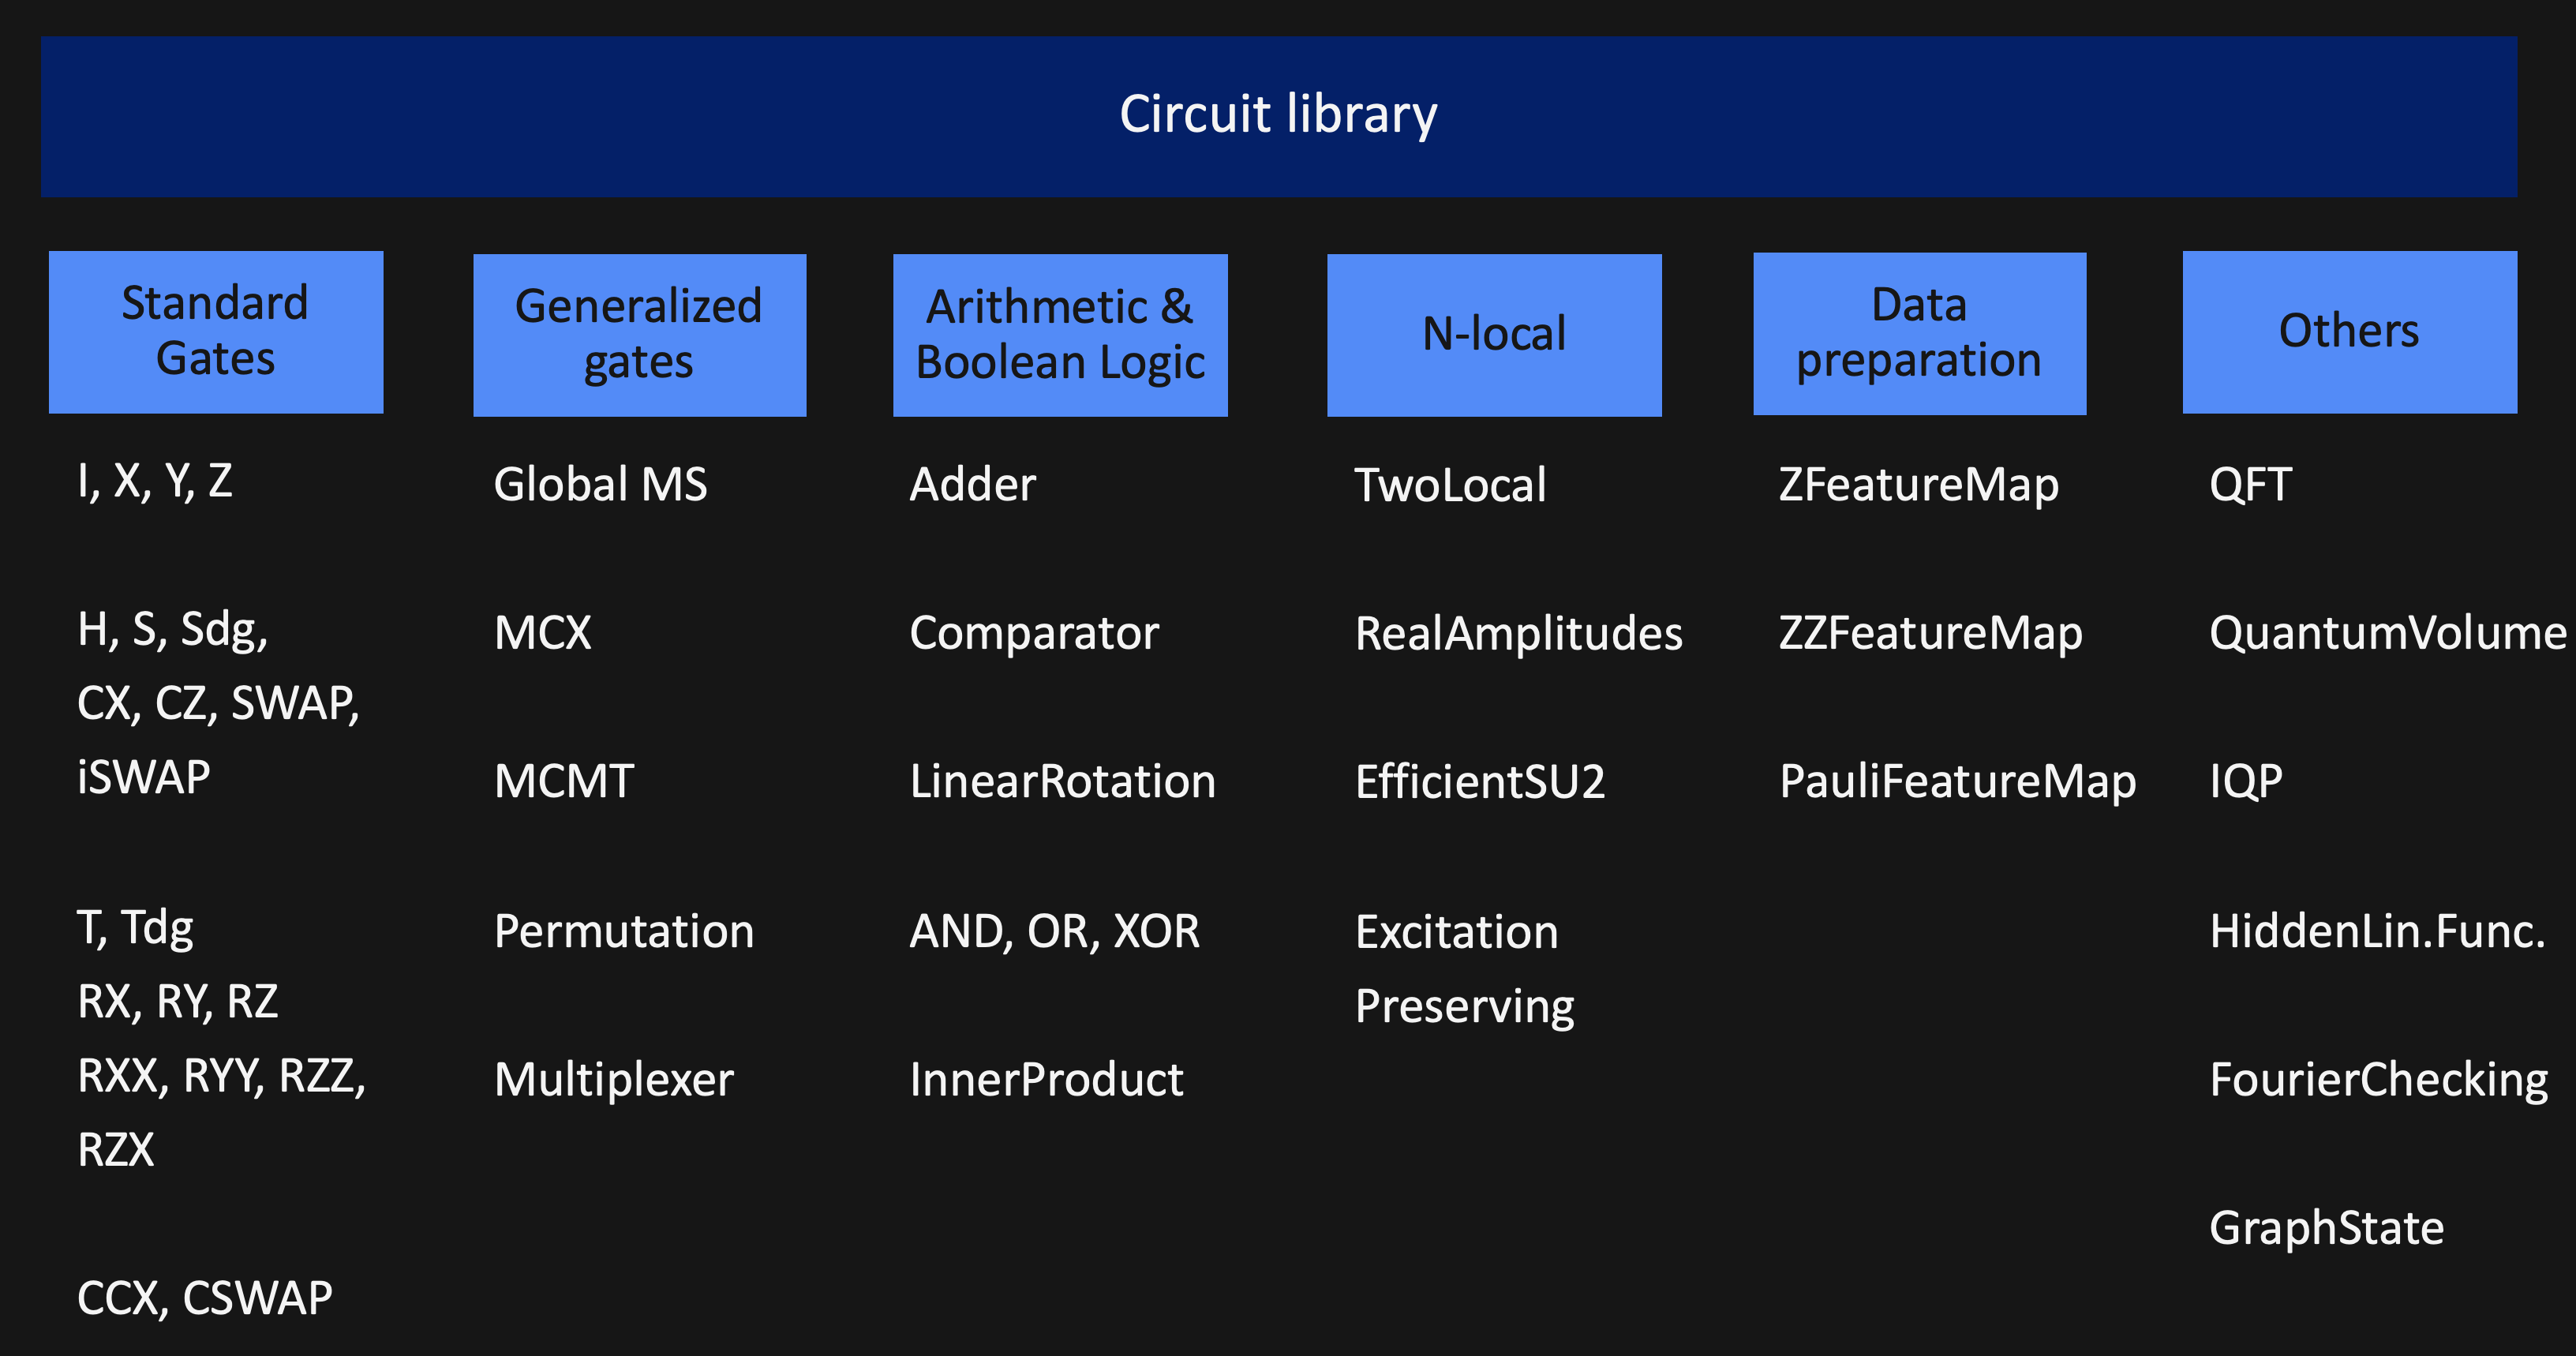

### 2. Provide out-of-the-box functions, and combine them like legos

Quantum circuits can be used to compute functions, just like classical library calls. A good example of this is Fourier transform which is exponentially faster on a quantum computer. It was discovered at IBM Research [1]. We further show how circuits can be combined with each other as building blocks to build more complex transformations, such as the Hartley transform [2]. We will use the quantum_info module to analyze each of these, and will discuss how circuits can be optimized and offered as a service. Lastly we discuss how Qiskit Aqua can natively work with this library.

[1] [D. Coppersmith, An approximate Fourier transform useful in quantum factoring, 1994](https://arxiv.org/abs/quant-ph/0201067)

[2] [A. Klappenecker, M. Roettler, Quantum Software Reusability, 2003](https://arxiv.org/abs/quant-ph/0309121)

In [7]:
def plot_classical_vs_quantum(classical, quantum):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    width = 0.5

    ax[0].bar(np.arange(0, 2**num_qubits)-width/2, np.real(classical), width)
    ax[0].bar(np.arange(0, 2**num_qubits)+width/2, np.real(quantum), width)
    ax[0].set_title('real')
    ax[0].legend(['classical', 'quantum'])

    ax[1].bar(np.arange(0, 2**num_qubits)-width/2, np.imag(classical), width)
    ax[1].bar(np.arange(0, 2**num_qubits)+width/2, np.imag(quantum), width)
    ax[1].set_title('imaginary')
    ax[1].legend(['classical', 'quantum'])

    return fig   # utility plotting function

#### c) Fourier Transform

In [8]:
import numpy as np
import qiskit as qk
import qiskit.quantum_info as qi

num_qubits = 6
qft = qk.circuit.library.QFT(num_qubits, insert_barriers=True)
qft.draw(fold=500, reverse_bits=True)

┌───┐                                      ░                                    ░                            ░                     ░              ░       ░          
q_5: ┤ H ├─■──────■──────■──────■───────■───────░────────────────────────────────────░────────────────────────────░─────────────────────░──────────────░───────░──X───────
     └───┘ │pi/2  │      │      │       │       ░ ┌───┐                              ░                            ░                     ░              ░       ░  │       
q_4: ──────■──────┼──────┼──────┼───────┼───────░─┤ H ├─■──────■──────■──────■───────░────────────────────────────░─────────────────────░──────────────░───────░──┼──X────
                  │pi/4  │      │       │       ░ └───┘ │pi/2  │      │      │       ░ ┌───┐                      ░                     ░              ░       ░  │  │    
q_3: ─────────────■──────┼──────┼───────┼───────░───────■──────┼──────┼──────┼───────░─┤ H ├─■──────■──────■──────░─────────────────────░──────────────░───────░──┼──┼──X─
                         │pi/8  │       │       ░              │pi/4  │      │       ░ └───┘ │pi/2  │      │      ░ ┌───┐               ░              ░       ░  │  │  │ 
q_2: ────────────────────■──────┼───────┼───────░──────────────■──────┼──────┼───────░───────■──────┼──────┼──────░─┤ H ├─■──────■──────░──────────────░───────░──┼──┼──X─
                                │pi/16  │       ░                     │pi/8  │       ░              │pi/4  │      ░ └───┘ │pi/2  │      ░ ┌───┐        ░       ░  │  │    
q_1: ───────────────────────────■───────┼───────░─────────────────────■──────┼───────░──────────────■──────┼──────░───────■──────┼──────░─┤ H ├─■──────░───────░──┼──X────
                                        │pi/32  ░                            │pi/16  ░                     │pi/8  ░              │pi/4  ░ └───┘ │pi/2  ░ ┌───┐ ░  │       
q_0: ───────────────────────────────────■───────░────────────────────────────■───────░─────────────────────■──────░──────────────■──────░───────■──────░─┤ H ├─░──X───────
                                                ░                                    ░                            ░                     ░              ░ └───┘ ░

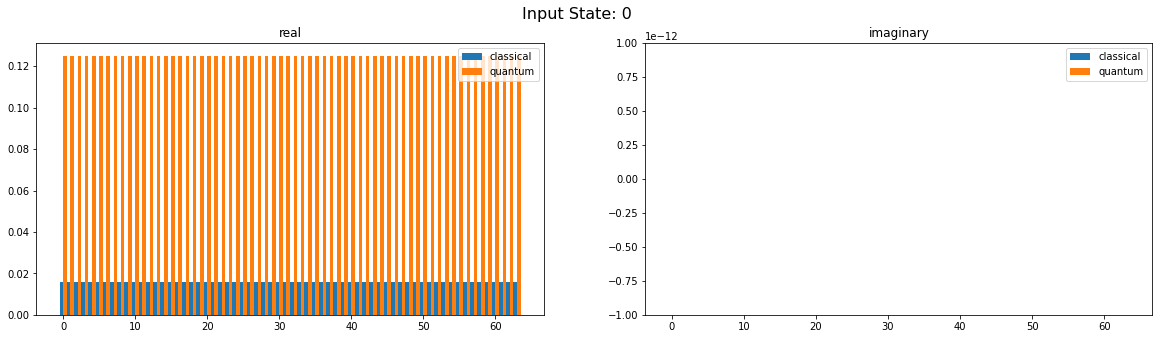

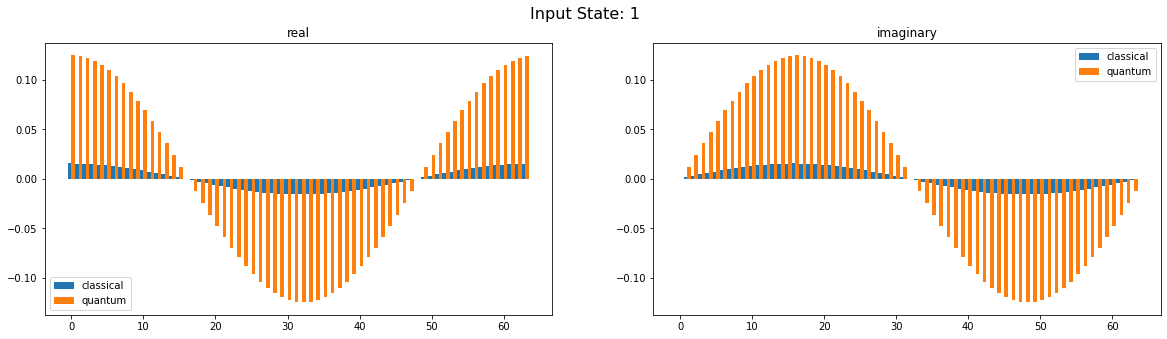

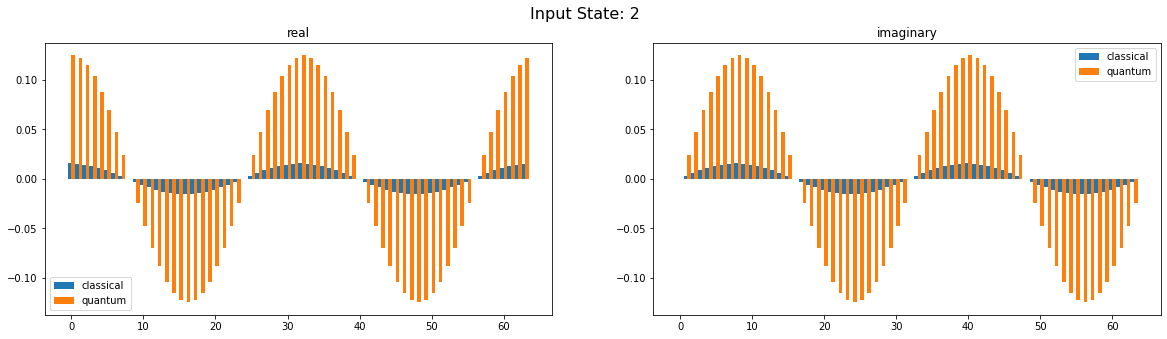

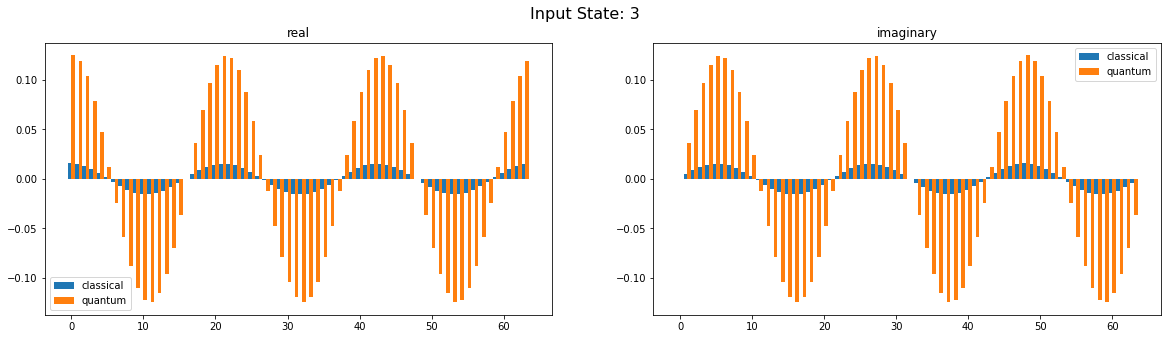

In [9]:
# Plot classical vs. quantum Fourier transform, for all basis states..
# By linearity of Fourier transform, all states map correctly.
# The difference in height is due to normalization in quantum.
for basis_state in [0, 1, 2, 3]:
    state = qi.Statevector.from_int(basis_state, dims=2**num_qubits)
    classical_fourier = np.fft.ifft(state.data)      # classical library function
    quantum_fourier = state.evolve(qft).data         # quantum library (simulation via quantum_info)
    fig = plot_classical_vs_quantum(classical_fourier, quantum_fourier);
    fig.suptitle('Input State: ' + str(basis_state), fontsize=16)

#### d) Hartley Transform (https://arxiv.org/pdf/quant-ph/0309121.pdf)

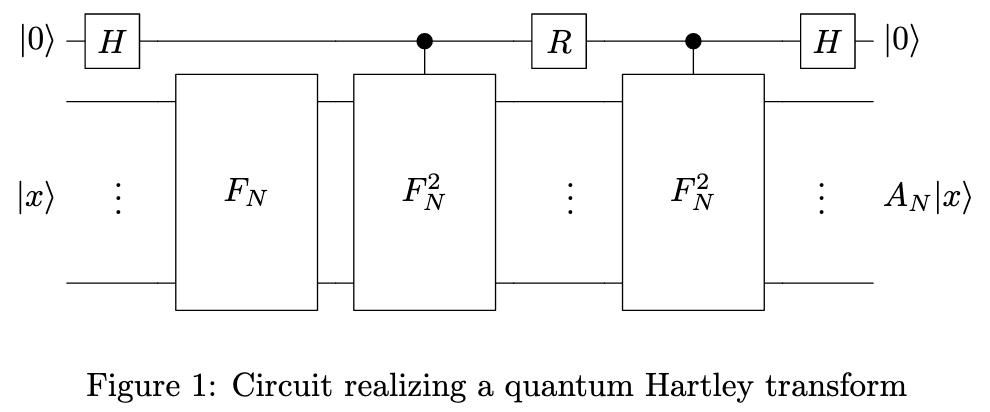

In [10]:
import numpy as np
import qiskit as qk
import qiskit.quantum_info as qi

num_qubits = 4
h = qk.circuit.library.HGate()                                # grab a Hadamard gate and QFT from circuit library.
qft = qk.circuit.library.QFT(num_qubits).to_gate()
r = qi.Operator(0.5*np.array([[1-1j, 1+1j], [1+1j, 1-1j]]))   # we can also drop a matrix in the circuit.

ctrl = qk.QuantumRegister(1, 'ctrl')
tgt = qk.QuantumRegister(num_qubits, 'x')
qht = qk.QuantumCircuit(tgt, ctrl)

qht = qht.compose(h, ctrl)                                    # start composing circuit from blocks.
qht = qht.compose(qft, tgt)
qht = qht.compose(qft.power(2).control(), [ctrl, *tgt[:]])    # notice ease of raising to power, controlling, etc.
qht = qht.compose(r, ctrl)
qht = qht.compose(qft.power(2).control(), [ctrl, *tgt[:]])    # optimized versions of each block can be used
qht = qht.compose(h, ctrl)                                    # in either the compiler, or backend.

qht.draw(reverse_bits=True)

┌───┐            ┌─────────┐          ┌───┐
ctrl_0: ─┤ H ├──────■─────┤ unitary ├────■─────┤ H ├
        ┌┴───┴─┐┌───┴────┐└─────────┘┌───┴────┐└───┘
   x_3: ┤3     ├┤3       ├───────────┤3       ├─────
        │      ││        │           │        │     
   x_2: ┤2     ├┤2       ├───────────┤2       ├─────
        │  qft ││  qft^2 │           │  qft^2 │     
   x_1: ┤1     ├┤1       ├───────────┤1       ├─────
        │      ││        │           │        │     
   x_0: ┤0     ├┤0       ├───────────┤0       ├─────
        └──────┘└────────┘           └────────┘

To verify against classical Discrete Hartley Transform: the action of the Hartley transform is:

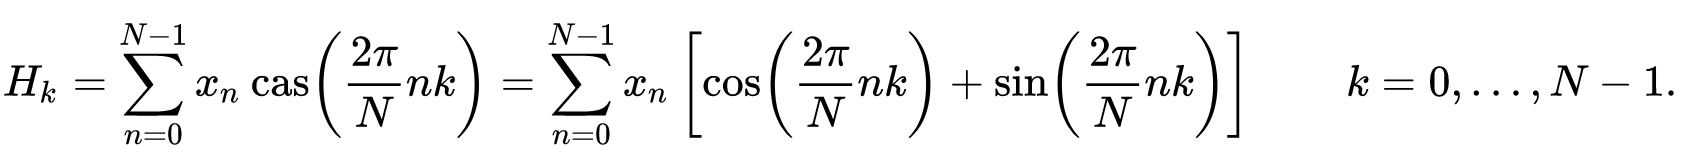

In [11]:
# Classical Hartley Transform

def DHT(x):
    N = x.size
    output = np.zeros(N, dtype=complex)
    for k in range(N):
        transform = 0
        for n in range(N):
            transform += x[n] * (np.cos(2*np.pi*n*k/N) + np.sin(2*np.pi*n*k/N))
        output[k] = transform
    return np.round(output/np.sqrt(N), 2)

In [12]:
# Test some random state with classical and quantum Hartley transform to ensure correctness.
# However Hartley transform maps real-valued functions to real-valued functions.
# Therefore our random state must have real amplitudes.

random_state = qi.random_statevector(2**num_qubits)                     # make a Haar random statevector
probs = random_state.probabilities()                                    # convert amplitudes to probabilities
data_state = qi.Statevector(np.sqrt(probs))                             # sqrt(probs) gives real amplitudes
print("random real-amplitude state (option 1)")
print(np.round(data_state.data, 2))

random real-amplitude state (option 1)
[0.12+0.j 0.13+0.j 0.22+0.j 0.04+0.j 0.32+0.j 0.17+0.j 0.12+0.j 0.09+0.j
 0.4 +0.j 0.34+0.j 0.32+0.j 0.34+0.j 0.18+0.j 0.13+0.j 0.43+0.j 0.21+0.j]


In [13]:
# quantum simulation
ancilla_state = qi.Statevector.from_label('0')               # use a clean ancilla
initial_state = ancilla_state.tensor(data_state)             # tensor product of ancilla and target
final_state = initial_state.evolve(qht)                      # evolve state through circuit
reduced_state = qi.partial_trace(final_state, [num_qubits])  # trace out ancilla
quantum_hartley = reduced_state.to_statevector().data        # ancilla was disentangled, get pure statevector

In [14]:
# classical simulation
classical_hartley = DHT(data_state.data)

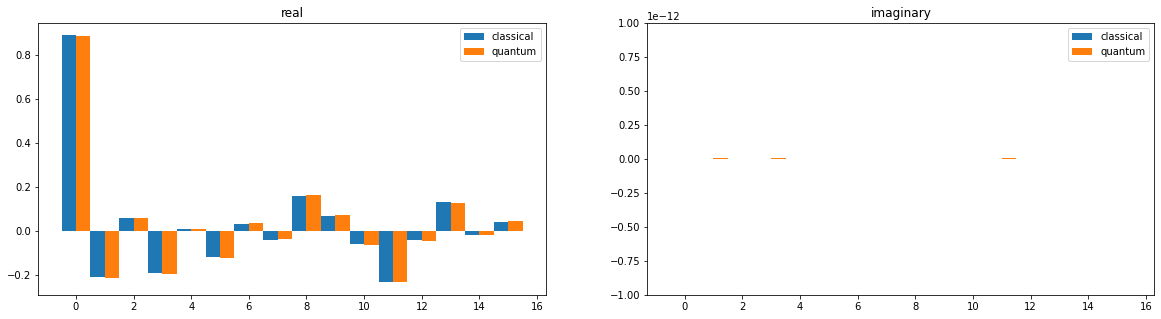

In [15]:
plot_classical_vs_quantum(classical_hartley, quantum_hartley);

#### e) Real-amplitude state preparation
Instead of manually constructing a state with real amplitudes, we can use a circuit to prepare this state for us. This is the **pattern** that prepares real-amplitudes states.

In [16]:
data_prep_circ = qk.circuit.library.RealAmplitudes(num_qubits)          # this circuit produces only real amps
random_angles = np.random.uniform(0, 2*np.pi, data_prep_circ.num_parameters)  # plug in some random parameters
data_prep_circ.assign_parameters(random_angles, inplace=True)
zero = qi.Statevector.from_int(0, 2**num_qubits)                        # evolve from |0..> to get desired state
data_state = zero.evolve(data_prep_circ)
print("random real-amplitude state (option 2)")
print(np.round(data_state.data, 2))

random real-amplitude state (option 2)
[ 0.13+0.j  0.05+0.j -0.12+0.j -0.06+0.j  0.18+0.j  0.01+0.j  0.34+0.j
 -0.37+0.j  0.3 +0.j  0.21+0.j -0.26+0.j  0.52+0.j -0.25+0.j -0.34+0.j
  0.14+0.j -0.11+0.j]


In [17]:
data_prep_circ.draw(fold=400)

┌────────────┐                    ┌────────────┐                                           ┌────────────┐                                           ┌───────────┐                            
q_0: ┤ RY(4.9899) ├──■────■─────────■──┤ RY(5.6189) ├────────────────────■─────────■─────────■──┤ RY(1.8888) ├────────────────────■─────────■─────────■──┤ RY(4.188) ├────────────────────────────
     ├────────────┤┌─┴─┐  │         │  └────────────┘┌────────────┐    ┌─┴─┐       │         │  └────────────┘┌────────────┐    ┌─┴─┐       │         │  └───────────┘┌────────────┐              
q_1: ┤ RY(3.3372) ├┤ X ├──┼────■────┼────────■───────┤ RY(2.0038) ├────┤ X ├───────┼────■────┼────────■───────┤ RY(5.9435) ├────┤ X ├───────┼────■────┼────────■──────┤ RY(2.8136) ├──────────────
     ├────────────┤└───┘┌─┴─┐┌─┴─┐  │        │       └────────────┘┌───┴───┴────┐┌─┴─┐┌─┴─┐  │        │       └────────────┘┌───┴───┴────┐┌─┴─┐┌─┴─┐  │        │      └────────────┘┌────────────┐
q_2: ┤ RY(5.1248) ├─────┤ X ├┤ X ├──┼────────┼─────────────■───────┤ RY(4.3686) ├┤ X ├┤ X ├──┼────────┼─────────────■───────┤ RY(3.4956) ├┤ X ├┤ X ├──┼────────┼────────────■───────┤ RY(2.0946) ├
     ├────────────┤     └───┘└───┘┌─┴─┐    ┌─┴─┐         ┌─┴─┐     ├────────────┤└───┘└───┘┌─┴─┐    ┌─┴─┐         ┌─┴─┐     ├────────────┤└───┘└───┘┌─┴─┐    ┌─┴─┐        ┌─┴─┐     ├────────────┤
q_3: ┤ RY(5.3205) ├───────────────┤ X ├────┤ X ├─────────┤ X ├─────┤ RY(4.1216) ├──────────┤ X ├────┤ X ├─────────┤ X ├─────┤ RY(3.3731) ├──────────┤ X ├────┤ X ├────────┤ X ├─────┤ RY(5.6897) ├
     └────────────┘               └───┘    └───┘         └───┘     └────────────┘          └───┘    └───┘         └───┘     └────────────┘          └───┘    └───┘        └───┘     └────────────┘

In [18]:
data_prep_circ = qk.circuit.library.RealAmplitudes(num_qubits)          # this circuit produces only real amps
random_angles = np.random.uniform(0, 2*np.pi, data_prep_circ.num_parameters)  # plug in some random parameters
data_prep_circ.assign_parameters(random_angles, inplace=True)
zero = qi.Statevector.from_int(0, 2**num_qubits)                        # evolve from |0..> to get desired state
data_state = zero.evolve(data_prep_circ)
print("random real-amplitude state (option 2)")
print(np.round(data_state.data, 2))

random real-amplitude state (option 2)
[-0.41+0.j  0.01+0.j -0.16+0.j -0.2 +0.j -0.24+0.j -0.01+0.j  0.26+0.j
  0.13+0.j -0.37+0.j -0.13+0.j  0.6 +0.j  0.09+0.j -0.05+0.j  0.06+0.j
 -0.19+0.j -0.24+0.j]


## 3. Circuits for Benchmarking

#### f) Quantum Volume (https://arxiv.org/pdf/1811.12926.pdf)

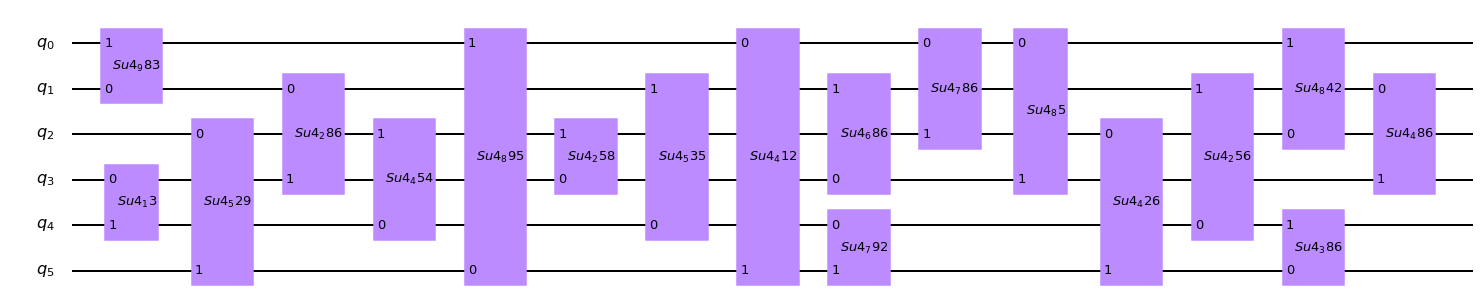

In [19]:
from qiskit.circuit.library import QuantumVolume
circ = QuantumVolume(num_qubits=6, depth=6)
circ.decompose().draw('mpl', fold=100)

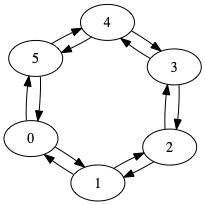

In [20]:
from qiskit.transpiler import CouplingMap
cmap = CouplingMap.from_ring(6)
cmap.draw()

In [21]:
from qiskit import transpile
new_circ = transpile(circ,
                     coupling_map=cmap, basis_gates=['u3', 'cz'],
                     layout_method='sabre', routing_method='sabre',
                     optimization_level=3,
                     seed_transpiler=10)

In [22]:
print(new_circ.depth(), new_circ.num_nonlocal_gates())

43 54


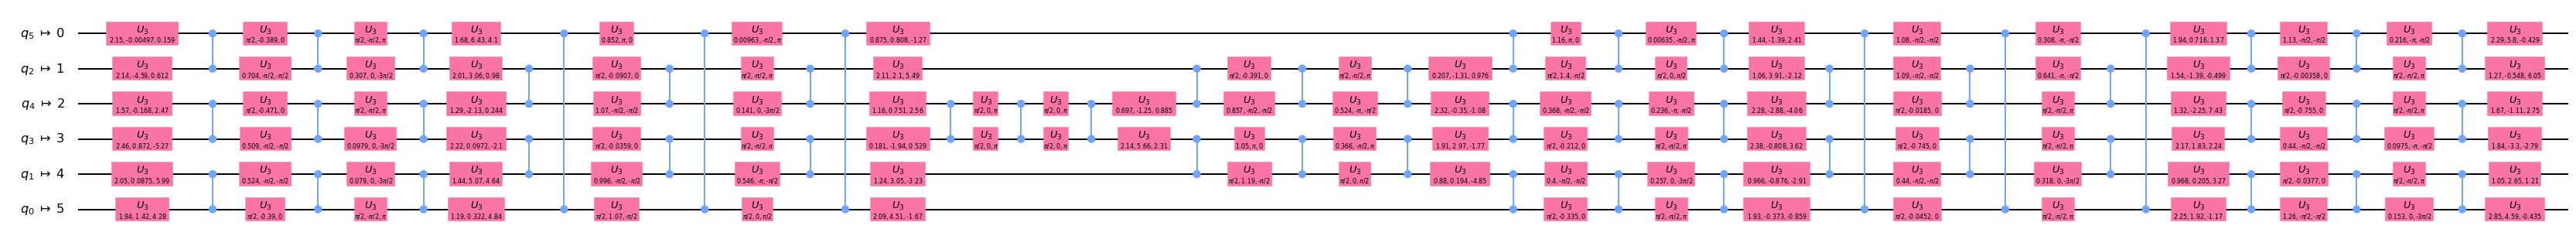

In [23]:
new_circ.draw('mpl', fold=100)

#### g) Graph states

Graph states are multi-particle entangled states that correspond to mathematical graphs, where the vertices of the graph take the role of quantum spin systems and edges represent Ising interactions.
https://arxiv.org/pdf/quant-ph/0307130.pdf

Each graph state is described by its stabalizers. 

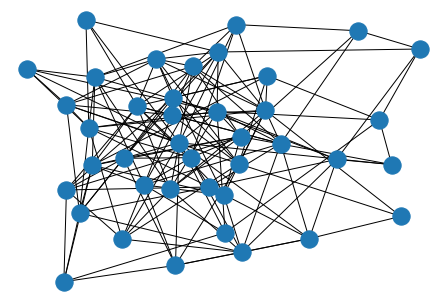

In [24]:
from qiskit.circuit.library import GraphState
import qiskit.tools.jupyter
import networkx as nx
import numpy as np

G = nx.Graph()
G = nx.fast_gnp_random_graph(40, .2)
adjmat = nx.adjacency_matrix(G)
nx.draw(G)

In [25]:
mat = adjmat.toarray()
circuit = GraphState(mat)       # circuit parameterized by a matrix.
%circuit_library_info circuit   # pretty printer for circuit library.

In [26]:
from typing import List

def get_stabilizers(mat):
    """Returns the stabilizers of the graph state constructed by A.
    
    Args:
        A: The adjacency matrix of the graph.
        
    Returns:
        The stabilizers.
    """
    stabilizers = []  # keep track of all stabilizers
    num_vertices = len(mat)
    for vertex_a in range(num_vertices):  
        stabilizer = [None] * num_vertices    # placeholder for Paulis
        for vertex_b in range(num_vertices):
            if vertex_a == vertex_b:          # self-connection --> 'X'
                stabilizer[vertex_a] = 'X' 
            elif mat[vertex_a][vertex_b] != 0:  # vertices connected --> 'Z'
                stabilizer[vertex_b] = 'Z'
            else:                             # else --> 'I'
                stabilizer[vertex_b] = 'I'
                
        # need to reverse for Qiskit's tensoring order
        stabilizers.append(''.join(stabilizer)[::-1])
        
    return stabilizers

In [27]:
from qiskit.quantum_info import Clifford
stablizers_from_matrix = get_stabilizers(mat)
stablizers_from_circuit_simulation = Clifford(circuit).stabilizer.pauli.to_labels()
stablizers_from_matrix == stablizers_from_circuit_simulation

True

In [28]:
stablizers_from_matrix

['IIIZIZIIIIIZIIIIZZZIIIIIIIIZZIIZIIIIIIIX',
 'IIIZIIIZIIIZIIIIZZIIIZIIIZIIIIZIIIIIIIXI',
 'IIIIIIIIZIZIIIZIIIIZIIZIZZIZIIZZIIZZIXII',
 'ZIIZIIIIIIIIIIZIIIIIIIIIIIIIIIZIIIIIXIII',
 'IIIIIIIIIIIIIZIIIIIIIIZIIIIIIIIIIIIXIZII',
 'ZIIIIIZIZIZZIIIIZIIIIIIIZZIIIIIIIIXIIZII',
 'ZIIIIIZIIIIIIIIZIIZIIIIIIIIIIIZIIXIIIIII',
 'IZZIIIIIIIIIIIIZIIIIIIIIIIZIIIIZXIIIIIII',
 'IIIZIIIIIZIIIIIIIIIIIIZIIIIIIIIXZIIIIZIZ',
 'IIIIIIZIIIIIIIIZIIZIZZIIIIIIZIXIIZIIZZZI',
 'ZIIIIZIZIIIZIZIIIZIIIIZIIIIIIXIIIIIIIIII',
 'IIIIIZZZIZIZIIIIIIIIIZIIIIIIXIZIIIIIIIIZ',
 'IIIZIIIZIIZIIIIIZZIIIIIIIIIXIIIIIIIIIZIZ',
 'ZIIIZIIIIIIIIIIIZIIIIIIIIIXIIIIIZIIIIIII',
 'ZIIIIIIIIIIIIIIIIIZIIIIZIXIIIIIIIIZIIZZI',
 'IIIZIIZIZZIIIIIIIZIIIIZIXIIIIIIIIIZIIZII',
 'IIZIIIIIZIIIIIIIZIIIIIIXIZIIIIIIIIIIIIII',
 'IIIIIIZIIZZIIIIIIIIIZIXIZIIIIZIZIIIZIZII',
 'IIIIZIIIZIIIZZIIIIIIIXIIIIIIZIZIIIIIIIZI',
 'ZIIIIIIZIIIIZIIIIZIZXIZIIIIIIIZIIIIIIIII',
 'ZIIZIIIZIIIIIIIZZIZXZIIIIIIIIIIIIIIIIZII',
 'IIIIIIIIIIZIIIIZIZXZIIIIIZIIIIZIIZIIIIIZ',
 'IZIIIIII

## 4. Circuits that are interesting from a complexity-theoretic perspective

#### h) Fourier Checking

Fourier checking is answering yes or no to the question of whether two classical functions (signals) are forrelated, meaning one has good overlap with the fourier transform of the other one. This is solvable in polynomial time on a quantum computer but not on a classical computer.

https://www.scottaaronson.com/papers/bqpph.pdf

Example:

| input || f || g |
| --- || --- || --- |
| 00 || 0 || 0 |
| 01 || 1 || 0 |
| 10 || 1 || 1 |
| 11 || 1 || 1 |

In [29]:
import qiskit.quantum_info as qi
from qiskit.circuit.library import FourierChecking
from qiskit.visualization import plot_histogram

f = [1, -1, -1, -1]  # Oracles represented as diagonal operators.
g = [1, 1, -1, -1]

circ = FourierChecking(f=f, g=g)
circ.draw()

┌───┐┌───────────────────────┐┌───┐┌──────────────────────┐┌───┐
q_0: ┤ H ├┤0                      ├┤ H ├┤0                     ├┤ H ├
     ├───┤│  DIAGONAL(1,-1,-1,-1) │├───┤│  DIAGONAL(1,1,-1,-1) │├───┤
q_1: ┤ H ├┤1                      ├┤ H ├┤1                     ├┤ H ├
     └───┘└───────────────────────┘└───┘└──────────────────────┘└───┘

Probability of observing the state |00..0> in this circuit is given by the following, so a frequent observation means the two classical functions are forrelated.

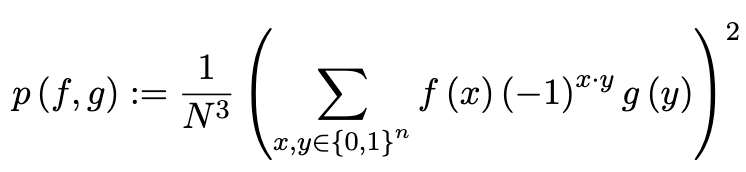

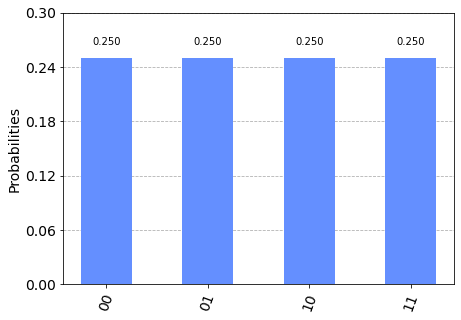

In [30]:
zero = qi.Statevector.from_label('00')
sv = zero.evolve(circ)
probs = sv.probabilities_dict()
plot_histogram(probs)

## Circuits in quantum algorithms

Next week with Julien...

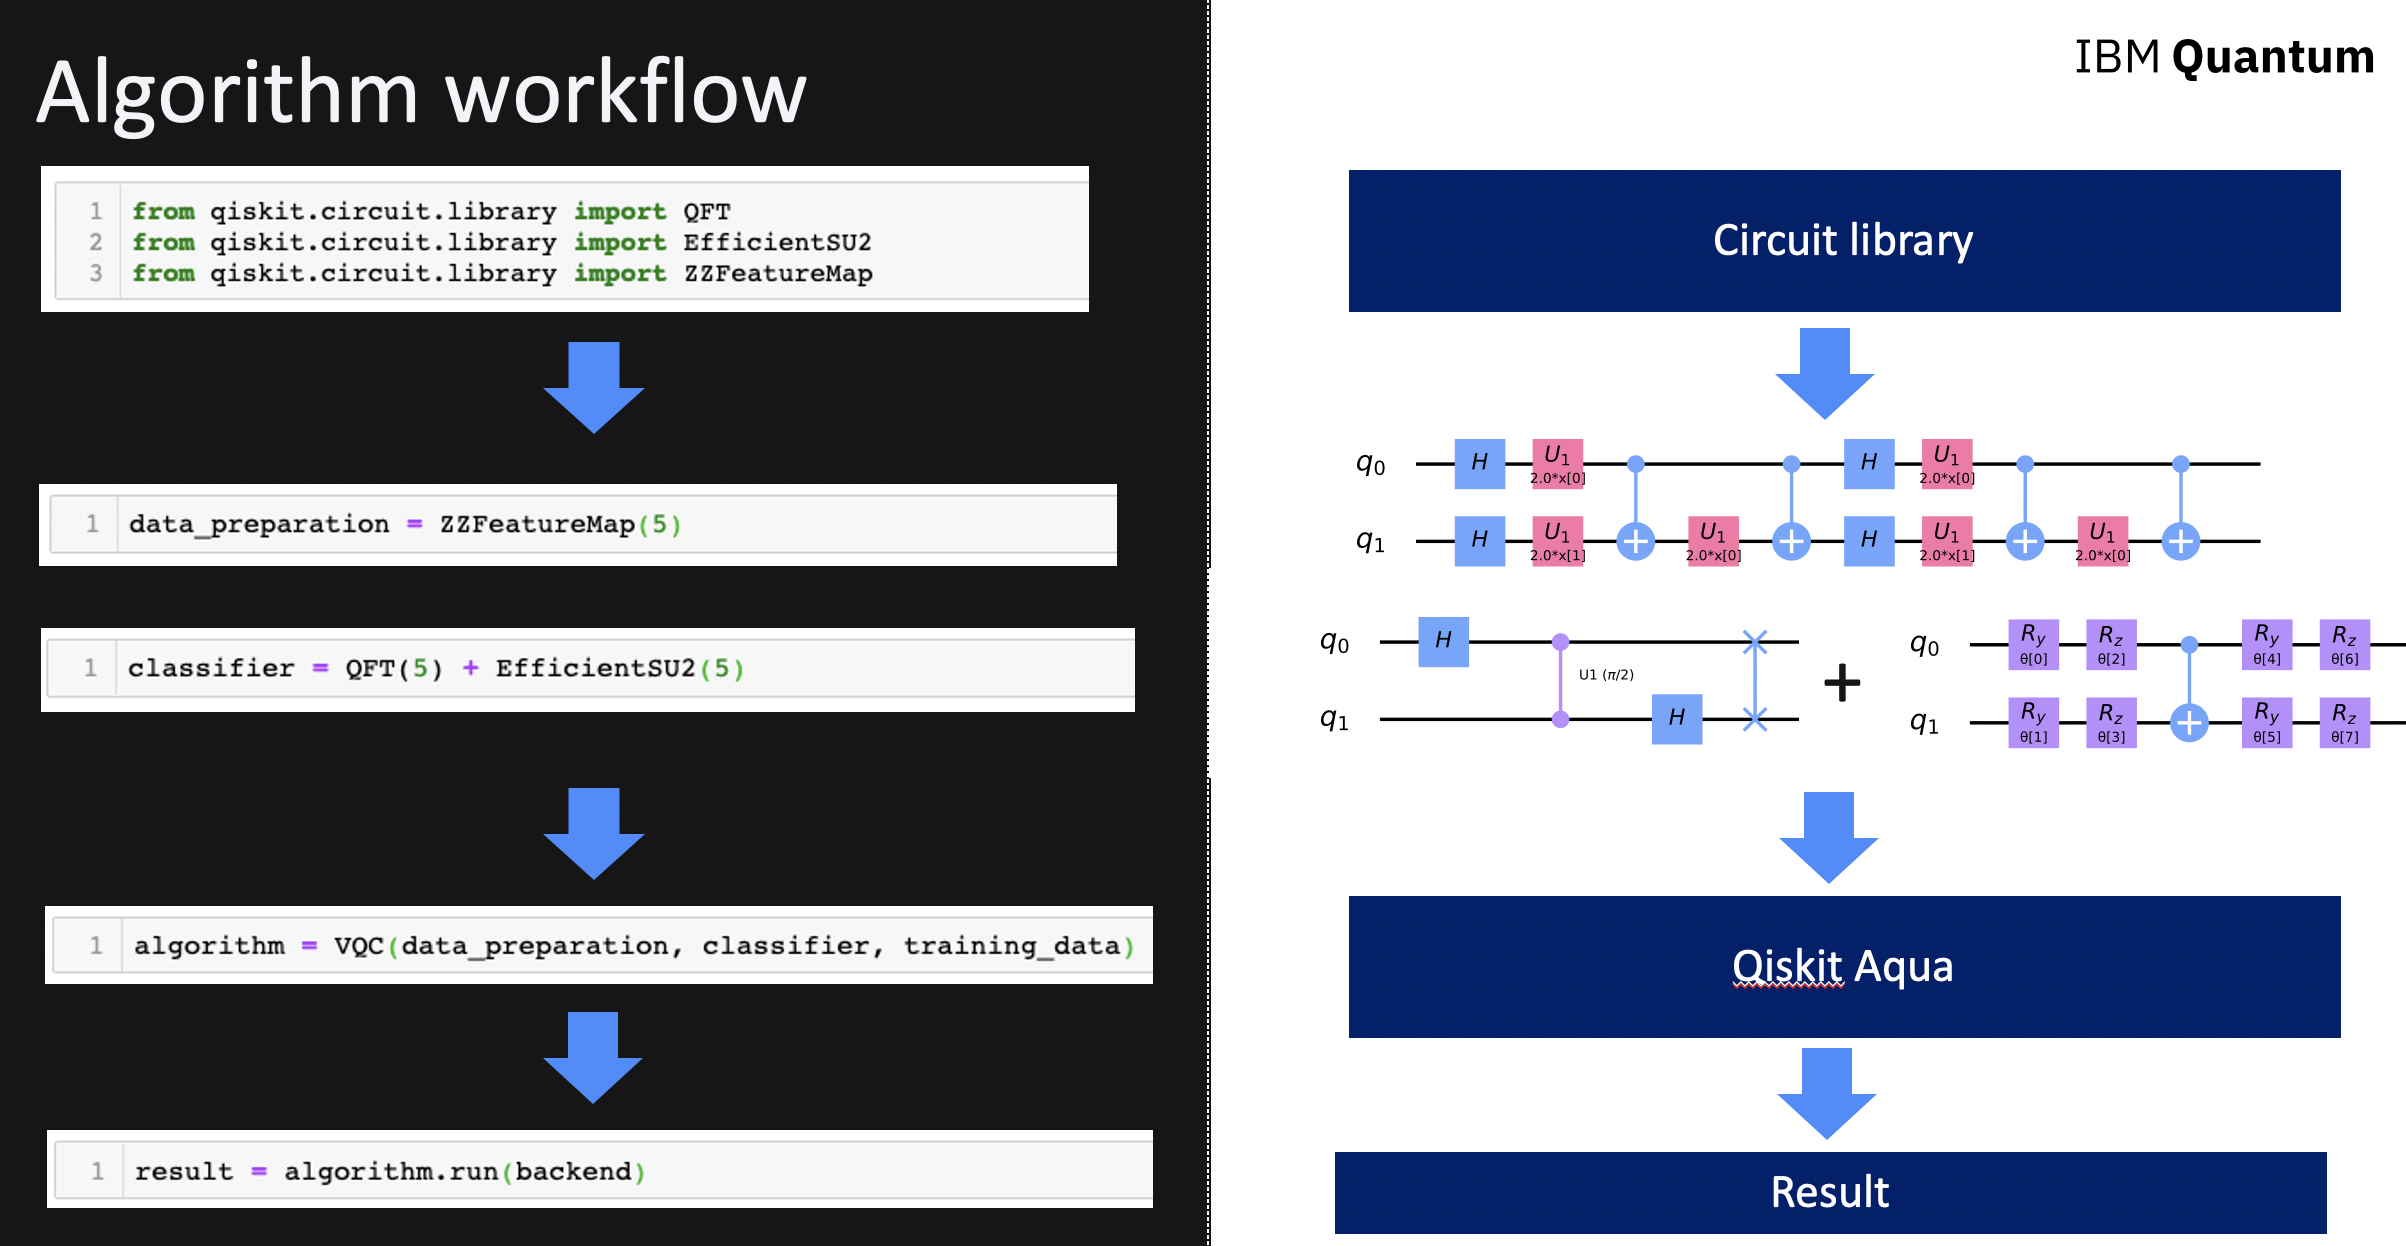

In [ ]:
import qiskit
import numpy as np

from qiskit.circuit.library import QFT
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import ZZFeatureMap

In [ ]:
training_data = {'A': np.asarray([[2.95309709, 2.51327412], [3.14159265, 4.08407045]]),
                 'B': np.asarray([[4.08407045, 2.26194671], [4.46106157, 2.38761042]])}
testing_data = {'A': np.asarray([[3.83274304, 2.45044227]]),
                'B': np.asarray([[3.89557489, 0.31415927]])}
feature_dimension = 2

In [ ]:
# the algorithm and circuit
from qiskit.aqua.algorithms import VQC

data_preparation = ZZFeatureMap(feature_dimension=feature_dimension, reps=2)
data_preparation.draw('latex', fold=200)

In [ ]:
data_preparation.reps = 4
data_preparation.draw('latex', fold=200)

In [ ]:
classifier = QFT(2) + EfficientSU2(num_qubits=data_preparation.num_qubits, reps=2)
classifier.draw('text', fold=200)

In [ ]:
# optimizer for the variational algorithm
from qiskit.aqua.components.optimizers import SLSQP
optimizer = SLSQP()

vqc = VQC(optimizer, data_preparation, classifier, training_data, testing_data)
result = vqc.run(qiskit.providers.aer.QasmSimulator(), seed_simulator=2, seed_transpiler=2)

In [ ]:
result